In [3]:
#imports
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#classifiers
#from mlxtend.classifier import StackingClassifier


%matplotlib inline



In [4]:

# Loading the data set
Train = pd.read_csv('train.csv')
Test = pd.read_csv('test.csv')
data = pd.concat([Train, Test])

In [5]:
data['Pclass_'] = data['Pclass'].astype('category')
data['SibSp_'] = data['SibSp'].astype('category')

## Understanding Data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 14 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Pclass_        1309 non-null category
SibSp_         1309 non-null category
dtypes: category(2), float64(3), int64(4), object(5)
memory usage: 136.0+ KB


In [7]:
data.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Pclass_', 'SibSp_'],
      dtype='object')

## Exploratory analysis 
### Let's begin some exploratory data analysis! We'll start by checking out missing data!

### Missing Data
##### We can use seaborn to create a simple heatmap to see where we are missing data!

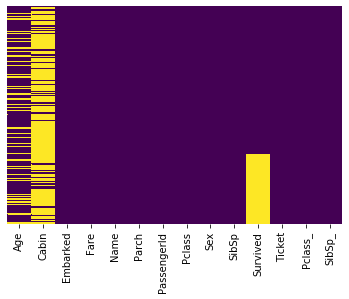

In [8]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

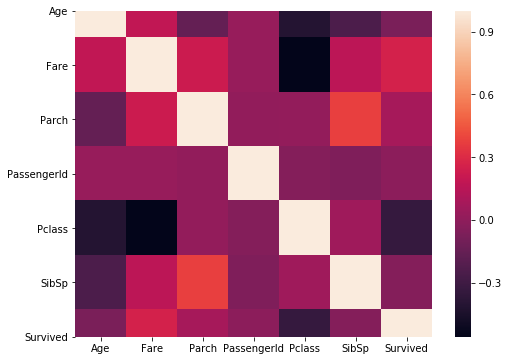

In [9]:
plt.figure(figsize=(8,6))
corr_ = data.corr() # calculating corr
# heatmap
sns.heatmap(corr_)

### Checking how many percentage of the data is missing 

In [10]:
# get the number of missing data points per column
missing_values_count = data.isnull().sum()
test_data_values_count = data.isnull().sum()
# look at the # of missing points in the first ten columns
missing_values_count[0:12]

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

#### As we can see that in the age column the number of values missing is 263 but the missing values in the Cabin column is 1014  It might be helpful to see what percentage of the values in our dataset were missing to give us a better sense of the scale of this problem:

In [11]:
total_cells = np.product(data.shape)
total_missing = missing_values_count.sum()
(total_missing/total_cells) * 100

9.265524391574811

### Let's continue on by visualizing some more of the data!

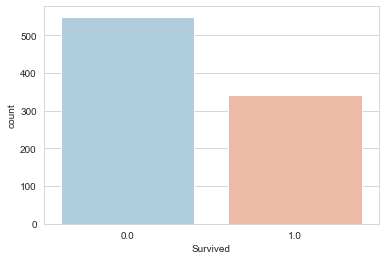

In [12]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=data,palette='RdBu_r')

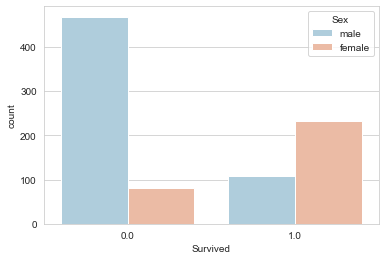

In [13]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=data,palette='RdBu_r')

#### In this plot it is clear number of female survivour is twice the number of male survivours. And the number of male passengers who couldnt survive is around 470. So in short the survival rate of the female is higher as compared to male passengers

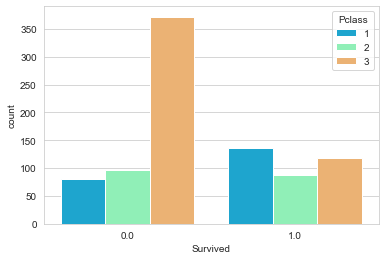

In [14]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=data,palette='rainbow')

#### In the above figure i tried to plot the survial of passeners with respect to different class types. It can be sen the the majority of the passenegers belonging to the class 3 couldnt survive. The survival rate of the passeneger in class 1 is higher  as compared to the other classes.

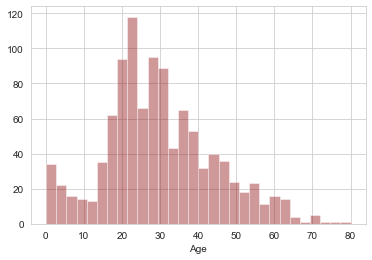

In [15]:
sns.distplot(data['Age'].dropna(),kde=False,color='darkred',bins=30)

#### In the above figure we can see that majority of th people traveling were of the age ranging from 20 -40.

In [16]:
# Alpha is to control figure float (0.0 transparent through 1.0 opaque)
#my_data['Age'].hist(bins=30,color='darkred',alpha=0.7)

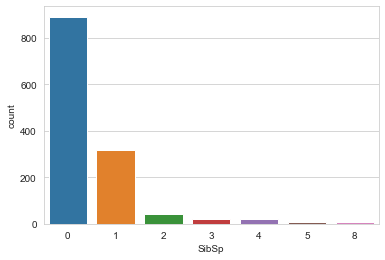

In [17]:
sns.countplot(x='SibSp',data=data)

### The above plot shows that majority of the people were traveling without any siblings 

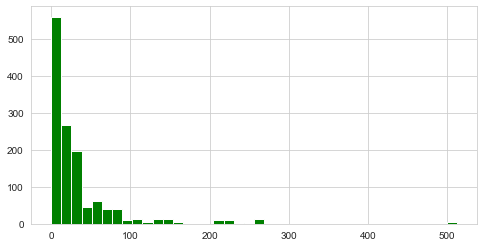

In [18]:
data['Fare'].hist(color='green',bins=40,figsize=(8,4))

### Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation). However we can be smarter about this and check the average age by passenger class. For example:

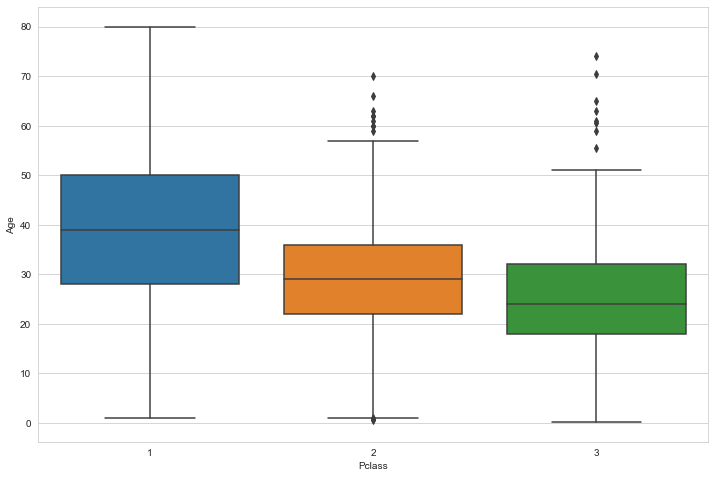

In [19]:
plt.figure(figsize=(12,8))
sns.boxplot(x='Pclass',y='Age',data=data)

We can see the wealthier passengers in the higher classes tend to be older

In [20]:
#def impute_age(cols):
 #   Age = cols[0]
  #  Pclass = cols[1]
   # if pd.isnull(Age):
    #    if Pclass == 1:
     #       return 37

      #  elif Pclass == 2:
       #     return 29

        #else:
         #   return 24

    #else:
        #return Age

data["Fare"].fillna(data.groupby("Sex")["Fare"].transform("mean"), 
                   inplace=True)
data["Age"].fillna(data.groupby(["Sex", "Fare"])["Age"].transform("mean"), 
                   inplace=True)
data["Age"].fillna(data.groupby(["Sex", "SibSp"])["Age"].transform("mean"), 
                   inplace=True)

In [46]:
#my_data['Age'] = my_data[['Age','Pclass']].apply(impute_age,axis=1)

In [47]:
data.fillna(method='ffill', inplace=True)

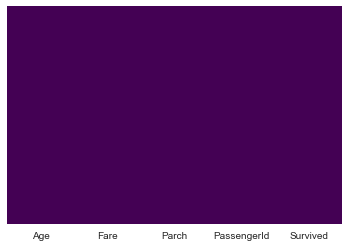

In [48]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

#### As we can see that there are not anymore empty values left 


### Converting Categorical Features
We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as input

In [49]:
dummy_mat = pd.get_dummies(data[['Sex', 'Embarked', 'Pclass_', 'SibSp_']], 
                           drop_first=True)
data.drop(['Name', 'Ticket', 'Cabin', 'Sex', 'Embarked', 'SibSp', 'Pclass', 'Pclass_', 'SibSp_'], 
          axis=1, inplace=True)
data_ = pd.concat([data, dummy_mat], axis=1)

KeyError: "None of [Index(['Sex', 'Embarked', 'Pclass_', 'SibSp_'], dtype='object')] are in the [columns]"

In [28]:
#my_data.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [29]:
#clean_data = pd.concat([my_data,sex,embark],axis=1)

In [30]:
#clean_data.head()

### Splitting combined data into test and train data

In [31]:
test_index = Test[['PassengerId']]
test_data = test_index.join(data_.set_index('PassengerId'), on='PassengerId')
train_index = Train[['PassengerId']]
train_data = train_index.join(data_.set_index('PassengerId'), on='PassengerId')
target_ = train_data['Survived']
train_data.drop(['Survived'], axis=1, inplace=True)
train_data.drop(['PassengerId'], axis=1, inplace=True)
test_id = test_data['PassengerId']
test_data.drop(['PassengerId', 'Survived'], axis=1, inplace=True)

### Feature Selection

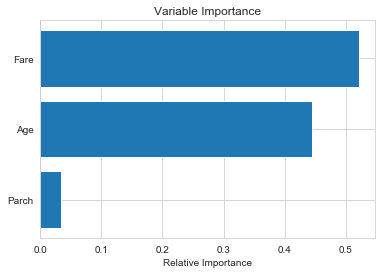

In [32]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
features = np.array(['Age', 'Fare', 'Parch'])
clf = RandomForestClassifier()
clf.fit(train_data[features], target_)
importances = clf.feature_importances_
sort_idx = np.argsort(importances)
padding = np.arange(len(features)) + 0.5
plt.barh(padding, importances[sort_idx], align='center')
plt.yticks(padding, features[sort_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

#### The best variable is Fare while the worst is Parch. It was decided to drop the column 'Parch'.


In [33]:
train_data_featured = train_data.drop(['Parch'], axis=1)
test_data_featured = test_data.drop(['Parch'], axis=1)

In [34]:
train_data_featured.head()

,Age,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass__2,Pclass__3,SibSp__1,SibSp__2,SibSp__3,SibSp__4,SibSp__5,SibSp__8
0,22.0,7.2500,1,0,1,0,1,1,0,0,0,0,0
1,38.0,71.2833,0,0,0,0,0,1,0,0,0,0,0
2,26.0,7.9250,0,0,1,0,1,0,0,0,0,0,0
3,35.0,53.1000,0,0,1,0,0,1,0,0,0,0,0
4,35.0,8.0500,1,0,1,0,1,0,0,0,0,0,0


### Standardize the Variables

In [35]:
from sklearn.preprocessing import StandardScaler


In [36]:
scaler = StandardScaler()

In [37]:
trainstandard=scaler.fit_transform(train_data_featured)

In [38]:
teststandar= scaler.fit_transform(test_data_featured)

### Building a Logistic Regression model

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(train_data, 
                                                    target_, test_size=0.20, stratify=target_,
                                                    random_state=101)

In [41]:
logmodel = LogisticRegression()

logmodel.fit(trainstandard,target_)
y_prob = logmodel.predict(teststandar)


y_prob_ = [int(i) for i in y_prob]
dict_results = {'PassengerId': test_id.values, 'Survived': y_prob_}
y_p_dataframe = pd.DataFrame(dict_results)
print('writing csv file')
y_p_dataframe.to_csv('csv32.csv', header=True, index=False)
print('my csv file')


#logmodel.fit(train_data,target_)

writing csv file
my csv file


In [42]:
c = range(1, 30, 5)
itr = range(1, 200, 40)
rnd = range(1, 5, 2)
param_grid = {'C': c, 'max_iter': itr, 'random_state': rnd}
model = LogisticRegression()

logreg_cv = GridSearchCV(model, param_grid, cv=5)
logreg_cv.fit(trainstandard, target_)
        # Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 1, 'max_iter': 41, 'random_state': 1}
Best score is 0.8170594837261503
